In [1]:
%matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import tensorflow as tf

import tqdm
import pandas as pd
import numpy as np

2021-12-14 11:24:15.447322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pani/anaconda3/envs/mlo-project-1/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-14 11:24:15.447364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def load_images(folder_path, remove_background=True):
    images = []
    filenames = []

    files_path = os.listdir(folder_path)

    for file in files_path:

        img = cv2.imread(folder_path + file)

        img = cv2.resize(img, (224,224))

        if remove_background:
            r = 112
            mask = np.zeros_like(img)
            mask = cv2.circle(mask, (round(r), round(r)), round(r), (255,255,255), -1)
            img = cv2.bitwise_and(img, mask)

        # maxi = np.max(img)
        # mini = np.min(img)
        
        images.append(img)
        
        filenames.append(file)

    return images, filenames

In [3]:
# load pd images
images, image_filenames = load_images("datasets/droplets/train/pd/")

In [4]:
image_filenames_comb = list(zip(images, image_filenames))

random.shuffle(image_filenames_comb)

images, image_filenames = zip(*image_filenames_comb)

In [5]:
def show_random_images(images, num_of_images_to_plot = 8):

    rand_indices = random.sample(range(0, len(images)), num_of_images_to_plot)

    figure, axis = plt.subplots(1, num_of_images_to_plot)

    for id in range(num_of_images_to_plot):
        axis[id].imshow(images[rand_indices[id]])

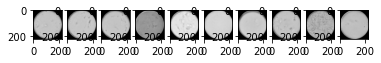

In [6]:
show_random_images(images, 10)

In [7]:
def normalize_images(images):
    images = np.array(images, dtype=np.float32)

    # Normalise the images
    images /= 255
    
    return images

In [8]:
images = normalize_images(images)

In [9]:
#images = np.random.shuffle(images)

In [10]:
images = images[:1000]

In [11]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

2021-11-23 15:17:23.982537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6678 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:83:00.0, compute capability: 7.5
2021-11-23 15:17:23.983245: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6678 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:84:00.0, compute capability: 7.5


In [12]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [13]:
vgg16_output = covnet_transform(vgg16_model, images)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

# vgg19_output = covnet_transform(vgg19_model, images)
# print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

# resnet50_output = covnet_transform(resnet50_model, images)
# print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

2021-11-23 15:17:28.457330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2021-11-23 15:17:29.144210: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-23 15:17:29.144821: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-23 15:17:29.144844: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2021-11-23 15:17:29.145478: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-11-23 15:17:29.145592: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


VGG16 flattened output has 25088 features


In [14]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [15]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
#vgg19_pca = create_fit_PCA(vgg19_output)
#resnet50_pca = create_fit_PCA(resnet50_output)

In [16]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

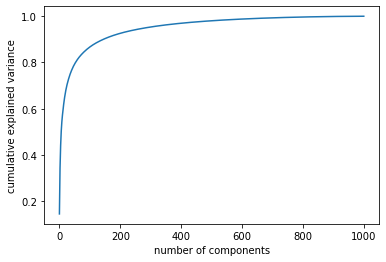

In [17]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
#pca_cumsum_plot(vgg19_pca)
#pca_cumsum_plot(resnet50_pca)


In [18]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
#vgg19_output_pca = vgg19_pca.transform(vgg19_output)
#resnet50_output_pca = resnet50_pca.transform(resnet50_output)

In [19]:
def create_train_kmeans(data, number_of_clusters):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, random_state=42)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [20]:
def create_train_gmm(data, number_of_clusters):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=42)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

In [21]:
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca, 20)

#print("\nVGG19")
#K_vgg19_pca = create_train_kmeans(vgg19_output_pca, 3)

#print("\nResNet50")
#K_resnet50_pca = create_train_kmeans(resnet50_output_pca, 3)

KMeans (PCA): 

VGG16
Training took 1.9685945510864258 seconds


In [22]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca, 20)

#print("\nVGG19")
#G_vgg19_pca = create_train_gmm(vgg19_output_pca, 10)

#print("\nResNet50")
#G_resnet50_pca = create_train_gmm(resnet50_output_pca, 10)

GMM (PCA): 

VGG16
Training took 4.68330717086792 seconds


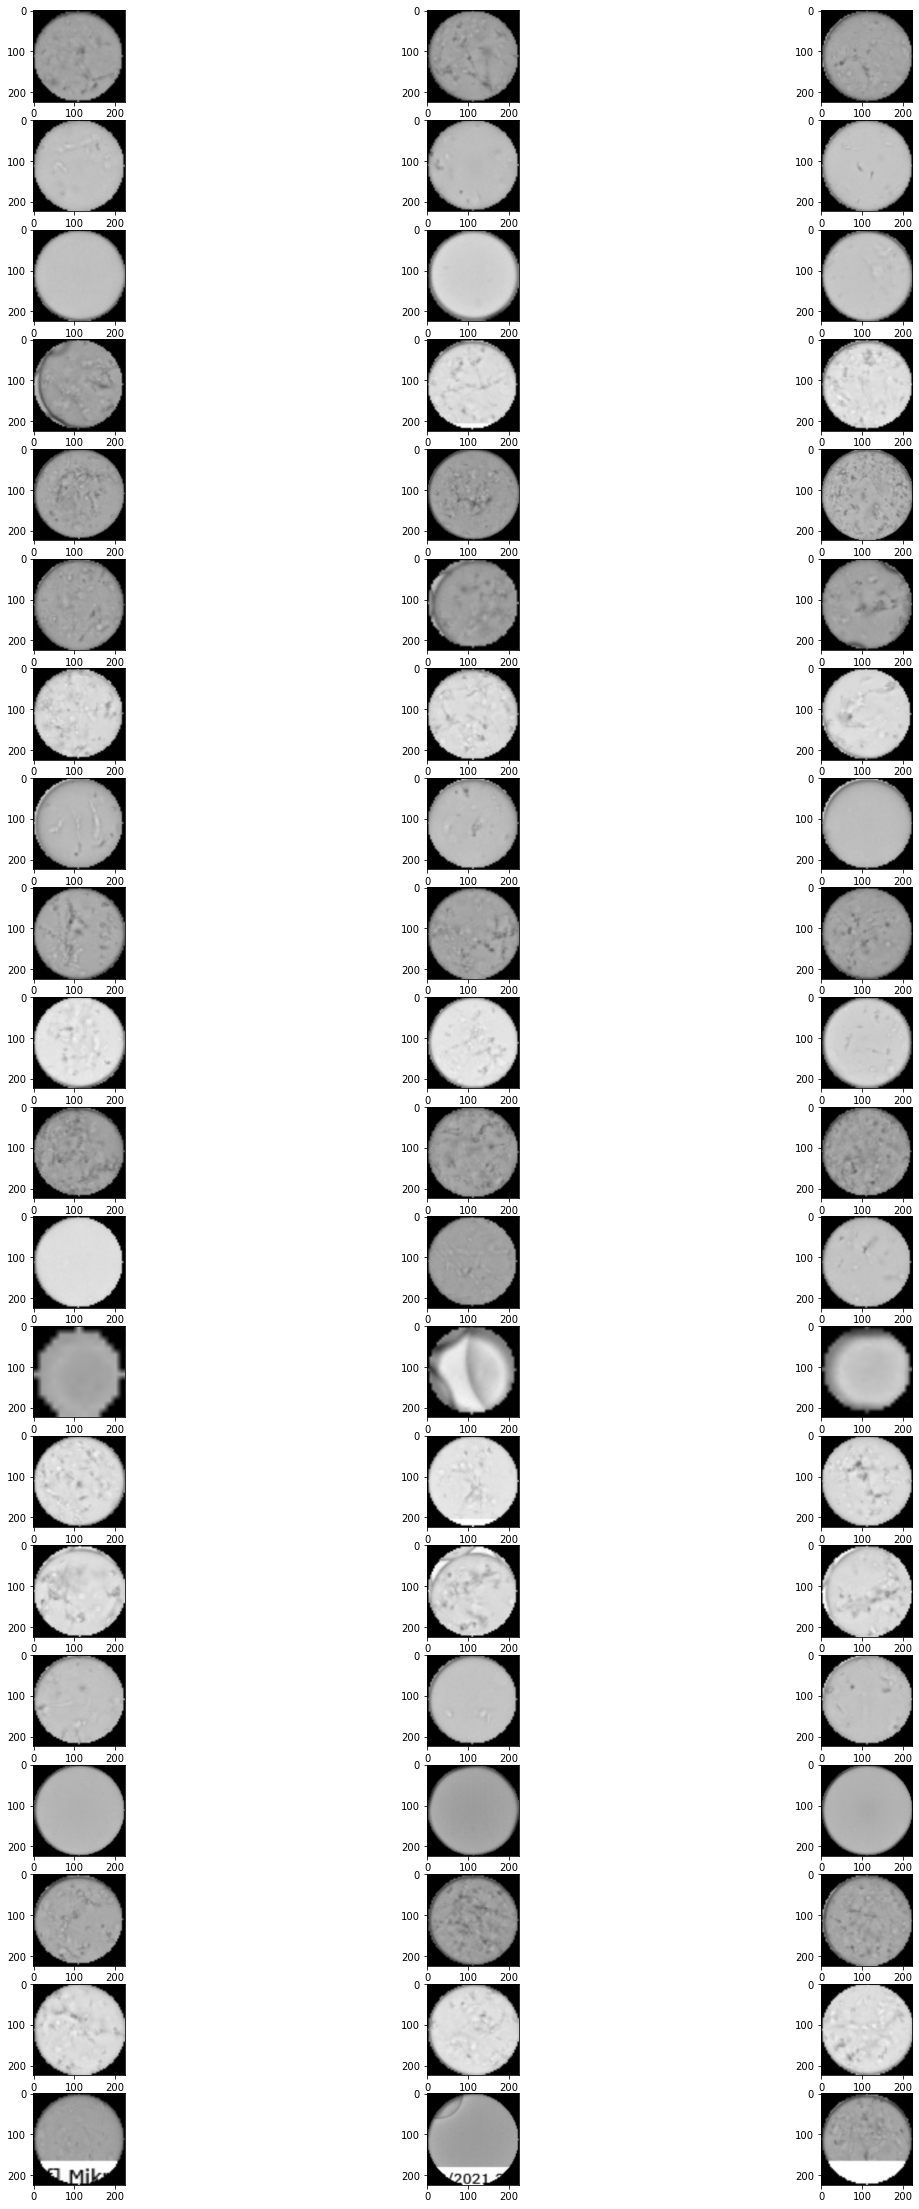

In [23]:
K_vgg16_pca_labels = K_vgg16_pca.labels_


figure, axis = plt.subplots(20, 3, figsize=(20, 40))

output_files = []
output_images = []

for cluster_id in range(20):
    index_of_image = np.where(K_vgg16_pca_labels == cluster_id)[0]
    for i in range(3):
        axis[cluster_id, i].imshow(images[index_of_image[i]])
        
        output_images.append(images[index_of_image[i]])
        output_files.append(image_filenames[index_of_image[i]])

In [26]:
from shutil import copyfile

for output_file in output_files:
    print(output_file)
    copyfile(f"datasets/droplets/train/pd/{output_file}", f"datasets/droplets/label-data/{output_file}")

353_bacteria-phage05-3h20E0000000000.jpg
10_bacteria-phage025-3h20D0000000000.jpg
167_bacteria-phage05-3h200000000000.jpg
195_2_hrs_bacteria_only_B0000000000.jpg
57_2_hrs_bacteria_only_B0000000000.jpg
201_bacteria_only_1hr.jpg
56_2_hrs_lambda_10_a0000000000.jpg
185_2_hrs_lambda_100000000000.jpg
232_2_hrs_bacteria_only_A0000000000.jpg
188_bacteria-phage025-3h20D0000000000.jpg
157_3_hrs_lambda_5_A0000000000.jpg
104_3_hrs_lambda_10_A0000000000.jpg
5_bacteria-3h20B0000000000.jpg
109_LB GFP lambda 10 1.jpg
90_LB FOS lambda 5 1.jpg
193_bacteria-3h20B0000000000.jpg
305_bacteria-phage025-3h20D0000000000.jpg
303_bacteria-phage025-3h20D0000000000.jpg
324_3_hrs_lambda_10_C0000000000.jpg
261_3_hrs_lambda_10_A0000000000.jpg
282_3_hrs_bacteria_only_C0000000000.jpg
55_2_hrs_bacteria_only_B0000000000.jpg
173_2_hrs_bacteria_only_B0000000000.jpg
290_2_hrs_lambda_10_a0000000000.jpg
45_bacteria-3h20B0000000000.jpg
278_bacteria-phage05-3h20E0000000000.jpg
35_bacteria-phage05-3h20C0000000000.jpg
265_3_hrs_b